In [1]:
import intake
from easygems import healpix as egh
from global_land_mask import globe
import intake
import cartopy.crs as ccrs
import uxarray as ux
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
experiment = cat.ICON["ngc3028"]

In [3]:
data = experiment(time="PT30M", zoom=8).to_dask()#.chunk({"time": 1000})
data = data.pipe(egh.attach_coords)
var="sfcwind"
long_name = data[var].attrs.get("long_name", var)

/home/b/b383063/.local/share/mamba/envs/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [4]:
ds_region = (
    data[var]
    .where((data["lat"] > 0) & (data["lat"] < 50)&(data["lon"] >330) | (data["lon"] < 40),drop=True)
)

In [5]:
try:
    data_mean=xr.open_dataset("mean_ws.nc")
    e
except:
    data_mean=ds_region.mean(dim="time").compute()
    data_mean.to_netcdf("mean_ws.nc")

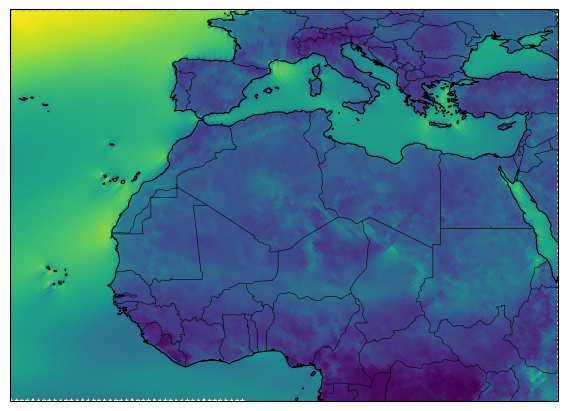

In [6]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-30, 40, 0, 50], crs=ccrs.PlateCarree())

egh.healpix_show(data_mean, ax=ax, cmap="viridis")
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

In [ ]:
U=ds_region
U_t=7
nu=1
DUP=U**3*(1+U_t/U)*(1-U_t**2/U**2)*(U>U_t)

In [6]:
DUP_mean=DUP.mean(dim="time").compute()

In [7]:
land_mask = ~globe.is_ocean(DUP_mean.lat, ((DUP_mean.lon + 180) % 360) - 180) 

In [8]:
DUP_mean

<xarray.DataArray 'sfcwind' (cell: 112466)> Size: 450kB
array([  3.0178165 ,   0.5227291 ,   0.17822333, ..., 129.4694    ,
       126.366356  , 149.79843   ], shape=(112466,), dtype=float32)
Coordinates:
    crs      int64 8B 0
  * cell     (cell) int64 900kB 674 680 681 682 ... 589481 589482 589483 589486
    lat      (cell) float64 900kB 4.481 4.63 4.78 4.78 ... -4.78 -4.63 -4.481
    lon      (cell) float64 900kB 39.9 39.73 39.9 39.55 ... 39.55 39.73 39.9

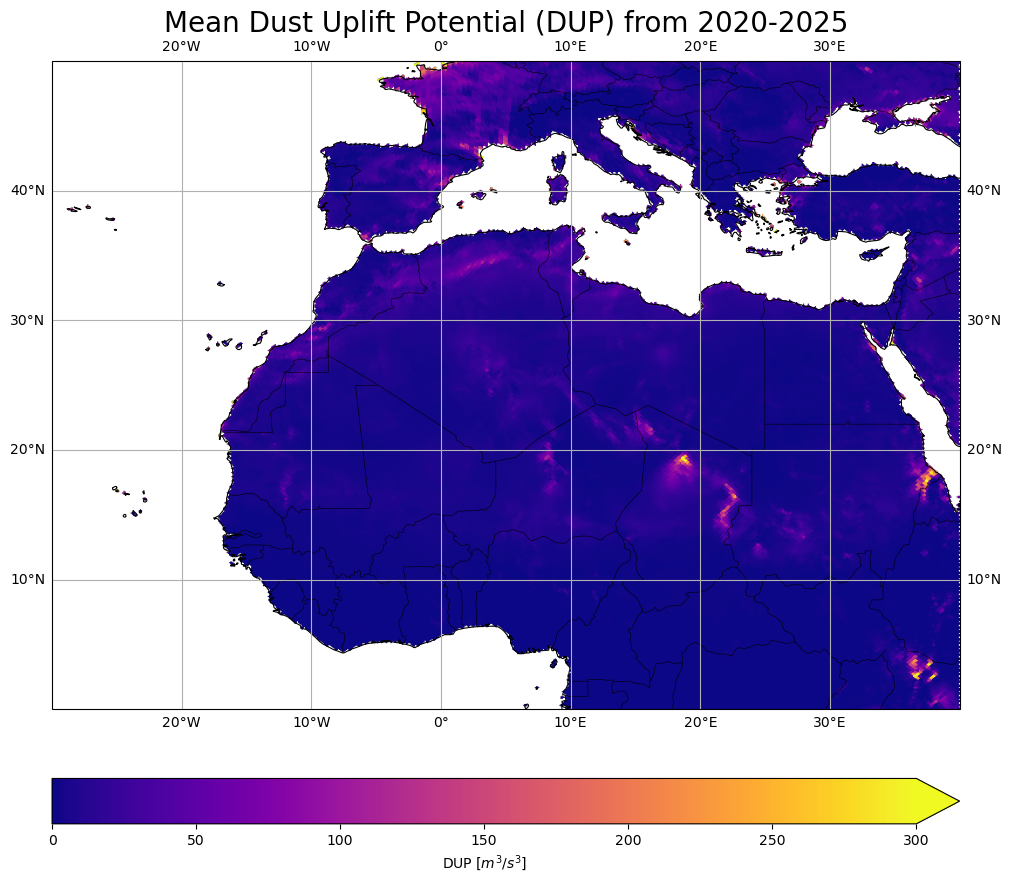

In [21]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(10,10), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-30, 40, 0, 50], crs=ccrs.PlateCarree())

im=egh.healpix_show(DUP_mean.where(land_mask), ax=ax, cmap="plasma",vmax=300)
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.gridlines(draw_labels=True)
# Titel setzen
ax.set_title("Mean Dust Uplift Potential (DUP) from 2020-2025", fontsize=20)
fig.colorbar(im, orientation='horizontal',location="bottom",label=r"DUP $[m^3/s^3]$",extend="max")
fig.savefig("DUP_ICON_Arne_Leuzinger.pdf")